<a href="https://colab.research.google.com/github/supravosengupta23/supravosengupta23/blob/main/Pothole_Detection_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install YOLO and dependencies
print("🔧 Installing YOLO and dependencies...")
!pip install ultralytics -q
!pip install roboflow -q
!pip install easyocr -q

# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import torch

# Colab specific imports
from google.colab import drive, files
from IPython.display import display, Image as IPImage

print("✅ Installation completed!")

# Check GPU availability
print(f"🖥️  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  GPU not available - Enable it: Runtime → Change runtime type → Hardware accelerator → GPU")


🔧 Installing YOLO and dependencies...
✅ Installation completed!
🖥️  CUDA available: True
🚀 GPU: Tesla T4
💾 GPU Memory: 14.7 GB


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Initialize YOLO model
print("📦 Loading YOLO model...")
model = YOLO('yolov8s.pt')  # Downloads automatically on first run

print("✅ YOLO model loaded successfully!")
print("Available model sizes: yolov8n.pt (fastest), yolov8s.pt (balanced), yolov8m.pt, yolov8l.pt, yolov8x.pt (most accurate)")


📦 Loading YOLO model...
✅ YOLO model loaded successfully!
Available model sizes: yolov8n.pt (fastest), yolov8s.pt (balanced), yolov8m.pt, yolov8l.pt, yolov8x.pt (most accurate)


In [5]:
# Option 1: Upload ZIP file directly
print("📤 Upload your dataset ZIP file:")
uploaded = files.upload()

# Extract uploaded ZIP
import zipfile
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    print(f"✅ Extracted {filename} to 'dataset' folder")

📤 Upload your dataset ZIP file:


Saving Pothole detection.v1i.yolov8.zip to Pothole detection.v1i.yolov8.zip
✅ Extracted Pothole detection.v1i.yolov8.zip to 'dataset' folder


In [6]:
print("📦 Loading YOLO model for pothole detection...")

# YOLOv8m is recommended for potholes (better accuracy for road textures)
model = YOLO('yolov8m.pt')

print("✅ Model loaded!")
print("🕳️ YOLOv8m chosen for optimal pothole detection performance")


📦 Loading YOLO model for pothole detection...
✅ Model loaded!
🕳️ YOLOv8m chosen for optimal pothole detection performance


In [7]:
import yaml

def setup_pothole_training(dataset_path="/content/dataset"):
    """Setup pothole detection training configuration"""

    # Create data.yaml for pothole detection
    config = {
        'path': str(Path(dataset_path).absolute()),
        'train': 'train/images',      # Adjust if your structure is different
        'val': 'valid/images',        # Adjust if your structure is different
        'test': 'test/images',        # Optional
        'nc': 1,                      # Number of classes (just potholes)
        'names': {0: 'pothole'}       # Class names
    }

    # Save configuration
    yaml_path = 'pothole_config.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print("✅ Pothole training configuration created!")
    print(f"📄 Config saved as: {yaml_path}")

    return yaml_path

# Setup configuration
# Assuming DATASET_PATH is defined elsewhere or you can use the default
# If DATASET_PATH is not defined, you can call the function without arguments:
config_file = setup_pothole_training()

✅ Pothole training configuration created!
📄 Config saved as: pothole_config.yaml


In [8]:
print("🚀 Starting Pothole Detection Training...")

# Training with pothole-optimized parameters
results = model.train(
    data="/content/pothole_config.yaml",
    epochs=100,                    # Adjust based on your needs
    imgsz=640,                     # Image size
    batch=16,                      # Batch size (reduce if GPU memory issues)
    lr0=0.01,                      # Learning rate
    patience=20,                   # Early stopping patience
    save=True,
    cache=True,
    device='auto',                 # Use GPU if available
    project='pothole_training',
    name='experiment_1',

    # POTHOLE-SPECIFIC OPTIMIZATIONS
    degrees=10.0,                  # Road angle variations (more than license plates)
    translate=0.1,                 # Position variations
    scale=0.3,                     # Size variations for different distances
    perspective=0.0003,            # Camera angle variations (vehicle mounted)
    flipud=0.0,                    # No vertical flip for roads
    fliplr=0.5,                    # Horizontal flip OK
    mosaic=1.0,                    # Excellent for small pothole detection
    mixup=0.15,                    # Helps with road texture learning
    copy_paste=0.3,                # Pothole augmentation

    # Loss function weights (important for precise pothole boundaries)
    cls=0.5,                       # Classification loss
    box=7.5,                       # Box regression loss (crucial for potholes)
    dfl=1.5,                       # Distribution focal loss

    plots=True,                    # Generate training plots
    verbose=True
)

print("✅ Training completed!")
print("📁 Best model saved at: pothole_training/experiment_1/weights/best.pt")


🚀 Starting Pothole Detection Training...
Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:auto (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/pothole_config.yaml, degrees=10.0, deterministic=True, device=auto, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=experiment_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr


image 1/47 /content/dataset/test/images/img-103_jpg.rf.4be35133f2dcff034b52c0faecaf7e2b.jpg: 640x640 1 pothole, 36.1ms
image 2/47 /content/dataset/test/images/img-129_jpg.rf.38249443839334de9cba6167940a9e2b.jpg: 640x640 3 potholes, 36.1ms
image 3/47 /content/dataset/test/images/img-149_jpg.rf.c9fad4510a9e1053d24861bd15f7ad4e.jpg: 640x640 1 pothole, 36.1ms
image 4/47 /content/dataset/test/images/img-150_jpg.rf.6d589c9bfd515d6c3f017402c74184a1.jpg: 640x640 1 pothole, 27.7ms
image 5/47 /content/dataset/test/images/img-167_jpg.rf.2faf0bcde27eba3198e3e1276accefbf.jpg: 640x640 1 pothole, 27.7ms
image 6/47 /content/dataset/test/images/img-175_jpg.rf.4a0a10af940b7eb144d9cec9b0721218.jpg: 640x640 2 potholes, 27.6ms
image 7/47 /content/dataset/test/images/img-181_jpg.rf.3f4dd7d0c8d7f0f867c2fb653231e4ad.jpg: 640x640 1 pothole, 27.3ms
image 8/47 /content/dataset/test/images/img-214_jpg.rf.029afe3a0da544c51de7c373b8077d74.jpg: 640x640 2 potholes, 27.3ms
image 9/47 /content/dataset/test/images/img-

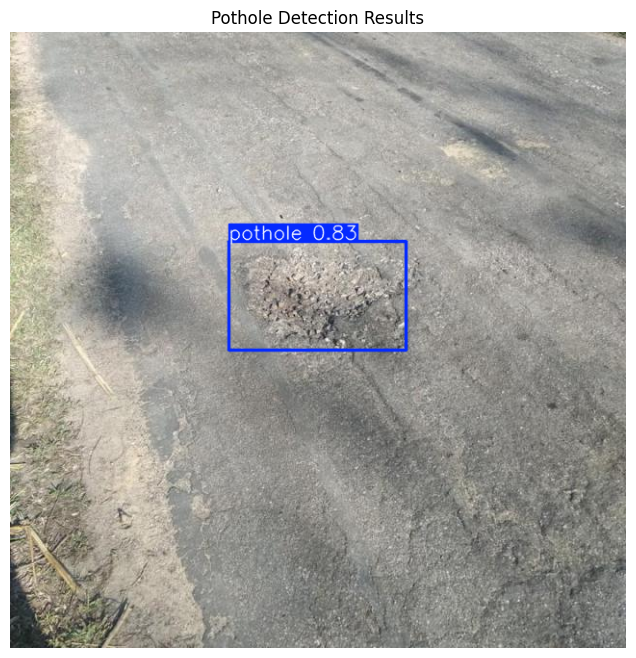

🕳️ Detected 1 pothole(s):
  Pothole 1: Confidence=0.828, Area=20789px²


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import torch

def test_pothole_model(model_path, test_image_path):
    """Test the trained pothole detection model"""

    # Load trained model
    trained_model = YOLO(model_path)

    # Run inference (lower confidence threshold for potholes)
    results = trained_model(test_image_path, conf=0.25)  # Lower threshold for subtle potholes

    # Display results
    result_img = results[0].plot()
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title('Pothole Detection Results')
    plt.show()

    # Print detection details
    boxes = results[0].boxes
    if boxes is not None:
        print(f"🕳️ Detected {len(boxes)} pothole(s):")
        for i, box in enumerate(boxes):
            conf = box.conf[0].item()
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            area = (x2-x1) * (y2-y1)
            print(f"  Pothole {i+1}: Confidence={conf:.3f}, Area={area:.0f}px²")
    else:
        print("✅ No potholes detected")

# Test the model (update paths as needed)
model_path = '/content/pothole_training/experiment_1/weights/best.pt'
test_image = '/content/dataset/test/images'  # Update this with an actual image file!

# Uncomment to test:
test_pothole_model(model_path, test_image)

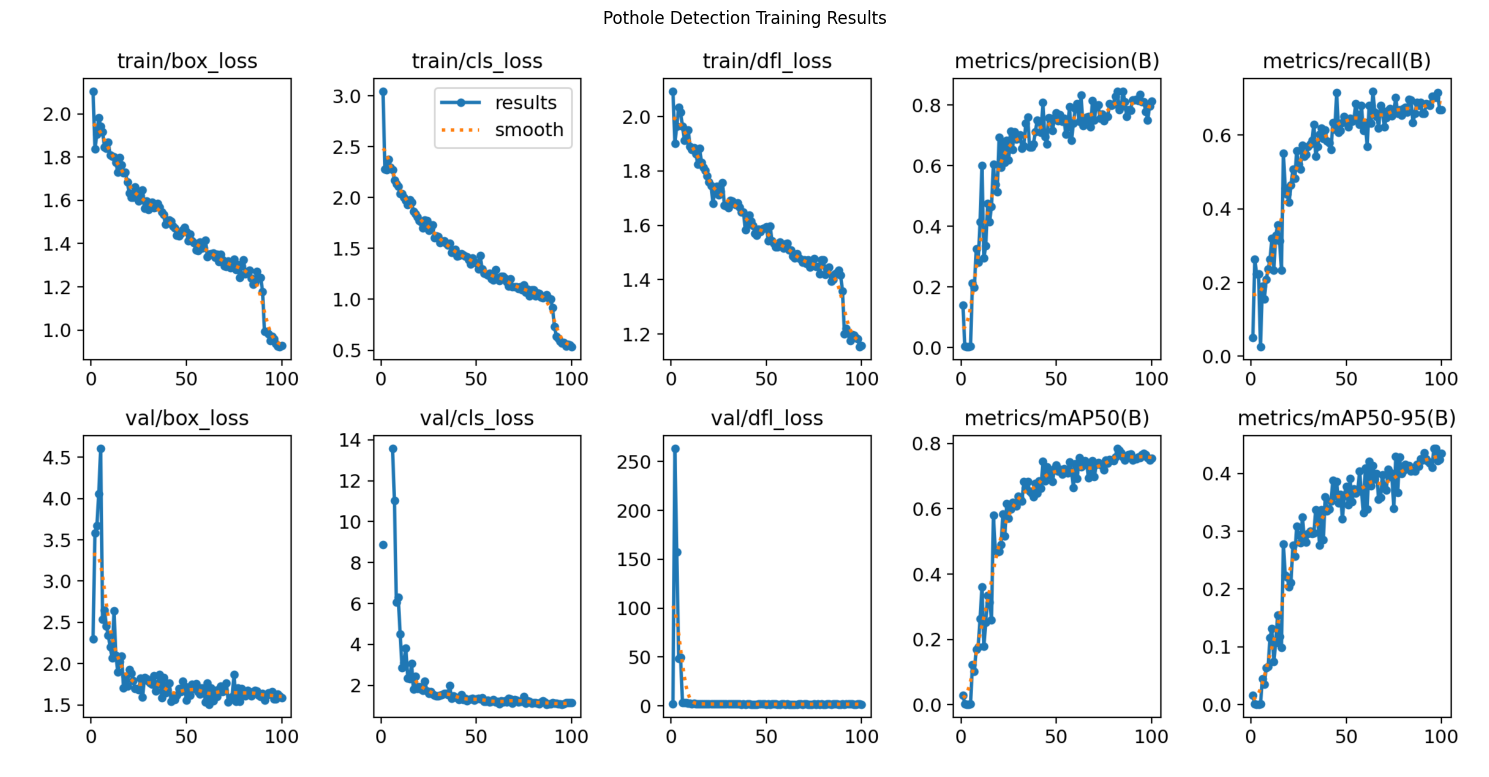

🎉 Pothole Detection Training Complete!


In [10]:
def show_training_results():
    """Display training results and metrics"""

    # Plot training results
    results_img_path = 'pothole_training/experiment_1/results.png'

    if Path(results_img_path).exists():
        img = plt.imread(results_img_path)
        plt.figure(figsize=(15, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Pothole Detection Training Results')
        plt.tight_layout()
        plt.show()
    else:
        print("Training results plot not found")

# Show results
show_training_results()

print("🎉 Pothole Detection Training Complete!")
